In [ ]:
import numpy as np
import scipy.linalg as la
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import colorsys
import matplotlib.colors as mc

width  = 3.402
height = width / 1.618

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

colorsAx=['tab:red', 'tab:green', 'tab:blue']
colorsBlack=['black']*3
I = np.array([[1,0,0],[0,1,0],[0,0,1]])

def wedge_so3(e):
    if e.shape != (3,):
        raise ValueError('wedge_so3: e should be a vector of length 3 and not ' + str(e.shape))
    return np.array([[0, -e[2], e[1]],
                     [e[2], 0, -e[0]],
                     [-e[1], e[0], 0]])
def vee_so3(E):
    if E.shape != (3,3):
        raise ValueError('vee_so3: e should be a 3x3 Matrix and not ' + str(E.shape))
    return np.array([E[2][1], E[0][2], E[1][0]])

def logm(R):
    theta = np.arccos((np.trace(R)-1)/2.)
    return .5 * theta/np.sin(theta) * (R - R.T)

def expm(S):
    if S.shape[0] != S.shape[1]:
        raise ValueError('expm: S should be a square skew-symmetric matrix ' + str(S.shape))
    return la.expm(S)

def curly_wedge_se3(e):
    if e.shape != (6,):
        raise ValueError('curly_wedge_se3: e should be a vector of length 6 and not ' + str(e.shape))
    rho = e[:3]
    phi = e[3:]
    return np.vstack([np.hstack([wedge_so3(phi), wedge_so3(rho)]), np.hstack([np.zeros((3, 3)), wedge_so3(phi)])])

def wedge_se3(e):
    if e.shape != (6,):
        raise ValueError('wedge_se3: e should be a vector of length 6 and not ' + str(e.shape))
    return np.vstack([np.hstack([wedge_so3(e[3:]), e[:3].reshape((3,1))]), np.zeros((1, 4))])

def cot(x):
    return 1./np.tan(x)

def jac_inv_so3(e):
    if e.shape != (3,):
        raise ValueError('jac_inv_so3: e should be a vector of length 3 and not ' + str(e.shape))
    
    if la.norm(e) < 1e-3:
        return I
    
    a = e/la.norm(e)
    phi=la.norm(e)
    return phi/2.*cot(phi/2.)*I + (1-phi/2.*cot(phi/2.))*xxT(a) - phi/2. * wedge_so3(a)

def jac_so3(e):
    if e.shape != (3,):
        raise ValueError('jac_so3: e should be a vector of length 3 and not ' + str(e.shape))
    
    if la.norm(e) < 1e-3:
        return I
        
    a = e/la.norm(e)
    phi=la.norm(e)
    
    return np.sin(phi)/phi*I + (1.-np.sin(phi)/phi)*xxT(a) + (1.-np.cos(phi))/phi*wedge_so3(a)

def jac_inv_se3(e):
    if e.shape != (6,):
        raise ValueError('jac_inv_se3: e should be a vector of length 6 and not ' + str(e.shape))
    return np.eye(6, 6) - 0.5 * curly_wedge_se3(e)

def add_error(previous_covariance, motion_covariance, previous_pose, dt):
    Je_inv = jac_inv_se3(previous_pose)
    Jo_inv = jac_inv_so3(previous_pose[3:])
    cov_rho_point_se3 = Jo_inv @ motion_covariance[:3, :3] @ Jo_inv.T
    motion_covariance_se3 = motion_covariance
    motion_covariance_se3[:3, :3] = cov_rho_point_se3
    return previous_covariance + Je_inv @ motion_covariance_se3 @ Je_inv.T * dt * dt

def unscented_transform(mean, covariance, f, kappa=0):
    n_x = mean.shape[0]
    omega = np.zeros((2*n_x+1))
    omega[0] = kappa / (n_x + kappa)
    for i in range(1, n_x+1):
        omega[i] = omega[i + n_x] = 1.0 / (2 * (n_x + kappa))
    chi = np.zeros((6, 2*n_x+1))
    chi[:,0] = mean
    # print(la.sqrtm((n_x + kappa) * covariance))
    for i in range(1, n_x + 1):
        chi[:,i] = mean + (la.sqrtm((n_x + kappa) * covariance))[:,i-1]
    for i in range(n_x + 1, 2*n_x + 1):
        chi[:,i] = mean - (la.sqrtm((n_x + kappa) * covariance))[:,i-n_x-1]
    gamma = np.zeros((4, 2*n_x+1))
    for i in range(2*n_x + 1):
        gamma[:,i] = f(chi[:,i])
        # print(gamma[:,i])
    final_mean = np.zeros((4,))
    for i in range(2*n_x + 1):
        final_mean += omega[i] * gamma[:,i]
    final_covariance = np.zeros((4, 4))
    for i in range(2*n_x+1):
        final_covariance += omega[i] * xxT(gamma[:,i] - final_mean)
    return final_mean, final_covariance

def propagate_error(point, pose_se3):
    return expm(wedge_se3(pose_se3)) @ point

def xxT(x):
    m = np.zeros(shape=(len(x), len(x)))
    for i in range(len(m)):
        for j in range(len(m[i])):
            m[i][j] = x[i]*x[j]
    return m

#------------------------------------------------------------------------------------------
def plot_rot(ax, C, colors=colorsAx, linestyle='-', planecolor='k'):
    for v,c in zip(I, colors):
        vr = np.dot(C,v)
        ax.plot([0,vr[0]],[0,vr[1]],[0,vr[2]], color=c, linestyle=linestyle)
    for n in np.linspace(0,.3, 20):
        vx = n*np.dot(C,I[0])
        vy = n*np.dot(C,I[1])
        ax.plot(*[(vx[i],vy[i]) for i in [0,1,2]], color=planecolor)


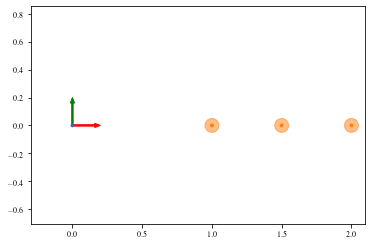

In [2]:
import math
from matplotlib import patches

pose = np.array([0, 0, 0, 0, 0, 0])
variance = np.eye(6, 6) * 0
point_cloud = [np.linspace(1, 2, 3), np.zeros(3), np.zeros(3)]
point_variances = []
for i in range(len(point_cloud[0])):
    point_variances.append(np.eye(3, 3) * 0.01)

fig, ax = plt.subplots(1, 1)
_ = ax.add_patch(patches.Arrow(pose[0], pose[1], 0.2 * math.cos(np.linalg.norm(pose[3:])), 0.2 * math.sin(np.linalg.norm(pose[3:])), 0.05, color="red"))
_ = ax.add_patch(patches.Arrow(pose[0], pose[1], 0.2 * -math.sin(np.linalg.norm(pose[3:])), 0.2 * math.cos(np.linalg.norm(pose[3:])), 0.05, color="green"))
_ = ax.add_patch(patches.Ellipse((pose[0], pose[1]), math.sqrt(variance[0, 0]), math.sqrt(variance[1, 1]), color="C0", alpha=0.5))
_ = ax.add_patch(patches.Circle((pose[0], pose[1]), 0.01, color="C0"))
for i in range(len(point_cloud[0])):
    ax.add_patch(patches.Ellipse((point_cloud[0][i], point_cloud[1][i]), math.sqrt(point_variances[i][0, 0]), math.sqrt(point_variances[i][1, 1]), color="C1", alpha=0.5))
    ax.add_patch(patches.Circle((point_cloud[0][i], point_cloud[1][i]), 0.01, color="C1"))
_ = ax.axis("equal")
_ = ax.set_xlim(-0.3, 2.1)

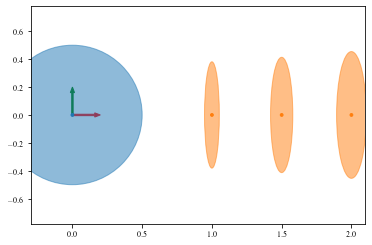

In [4]:
pose_error_std_lin = np.array([0.1, 0.2, 0.0])
pose_error_std_ang = np.array([0, 0, 1.5])

pose_error_variance = np.zeros((6, 6))
pose_error_variance[0, 0] = pose_error_std_lin[0]**2
pose_error_variance[1, 1] = pose_error_std_lin[1]**2
pose_error_variance[2, 2] = pose_error_std_lin[2]**2
pose_error_variance[3, 3] = pose_error_std_ang[0]**2
pose_error_variance[4, 4] = pose_error_std_ang[1]**2
pose_error_variance[5, 5] = pose_error_std_ang[2]**2

motion_covariance = np.eye(6, 6) * 0.01
motion_covariance[0, 0] = 1
motion_covariance[1, 1] = 1
current_pose_covariance = add_error(variance, motion_covariance, pose, 1)


point_variances = []
point_means = []
dummy_covariance = np.zeros((6, 6))
dummy_covariance[1,1] = 0.5
dummy_covariance[5,5] = 0.1


for i in range(len(point_cloud[0])):
    point = np.array([point_cloud[0][i], point_cloud[1][i], point_cloud[2][i], 1])
    f = lambda pose: propagate_error(point, pose)
    mean, cov = unscented_transform(np.zeros((6,)), dummy_covariance, f)
    point_means.append(mean)
    point_variances.append(cov)

fig, ax = plt.subplots(1, 1)
_ = ax.add_patch(patches.Arrow(pose[0], pose[1], 0.2 * math.cos(np.linalg.norm(pose[3:])), 0.2 * math.sin(np.linalg.norm(pose[3:])), 0.05, color="red"))
_ = ax.add_patch(patches.Arrow(pose[0], pose[1], 0.2 * -math.sin(np.linalg.norm(pose[3:])), 0.2 * math.cos(np.linalg.norm(pose[3:])), 0.05, color="green"))
_ = ax.add_patch(patches.Ellipse((pose[0], pose[1]), math.sqrt(current_pose_covariance[0, 0]), math.sqrt(current_pose_covariance[1, 1]), color="C0", alpha=0.5))
_ = ax.add_patch(patches.Circle((pose[0], pose[1]), 0.01, color="C0"))
for i in range(len(point_cloud[0])):
    ax.add_patch(patches.Ellipse((point_cloud[0][i], point_cloud[1][i]), math.sqrt(point_variances[i][0, 0]), math.sqrt(point_variances[i][1, 1]), color="C1", alpha=0.5))
    ax.add_patch(patches.Circle((point_cloud[0][i], point_cloud[1][i]), 0.01, color="C1"))
_ = ax.axis("equal")
_ = ax.set_xlim(-0.3, 2.1)